In [1]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import shutil

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

In [4]:
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

In [5]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [6]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

In [7]:
# Center data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean

In [8]:
#Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

In [9]:
#project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

(966, 150)
(322, 150)


In [10]:
import matplotlib.pyplot as plt

In [11]:

# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):

    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

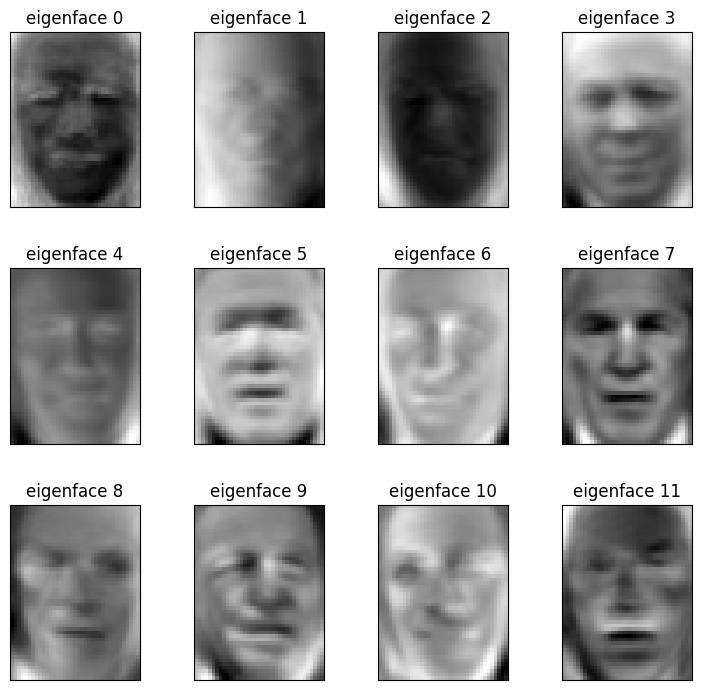

In [12]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()


(966,)


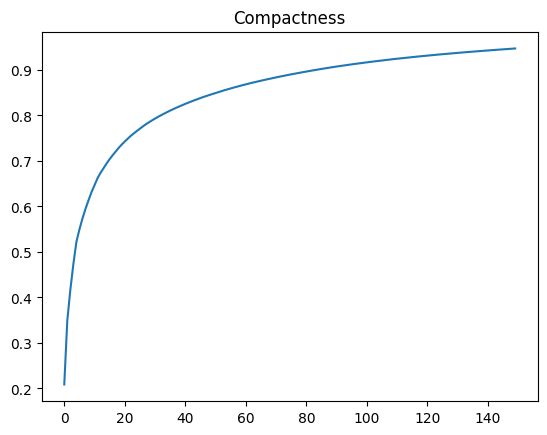

In [13]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [15]:
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]
4
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions [3 3 6 3 3 3 3 1 3 3 3 4 3 3 3 3 6 3 3 4 1 3 3 3 1 3 4 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 3 3 1 1 3 3 3 4 3 3 3 3 3 1 2 1 3 6 3 6 1 3 4 3 5 3 4 1 3 6 4 3 3
 3 2 1 6 3 3 6 3 3 3 3 3 3 3 3 3 3 6 3 3 1 3 1 1 1 6 3 3 3 3 3 3 3 3 3 1 3
 1 6 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 6 3 3 4 3 3 1 3 3 3 3 1 3 3 3 3
 3 1 1 3 1 3 3 3 6 3 3 3 6 5 5 1 3 1 5 1 3 3 3 3 3 1 5 3 3 3 3 5 3 3 3 3 3
 3 3 3 3 2 4 3 3 3 6 3 3 3 3 3 3 3 3 3 5 1 4 2 6 2 1 3 3 3 3 3 3 3 3 3 3 3
 3 1 1 3 3 3 1 3 3 3 3 3 3 1 3 6 3 3 3 4 3 3 3 3 3 3 3 6 4 4 3 4 3 4 3 1 3
 3 3 3 3 1 3 1 6 1 3 1 1 1 3 3 6 3 3 3 3 3 1 1 3 3 3 1 3 3 3 4 2 3 5 3 3 1
 3 5 3 3 3 6 3 3 1 3 3 3 1 3 3 3 1 3 1 3 3 3 3 3 4 3]
Which Correct: [ True  True  True  True  True  True False  True  True  True  True False
  True False  True  True False  True  True  True  True False  True False
 False False False  True  True  True False  True  True  True  True  True
  True  True  True  True  True False  True  True  True False False  True
 False  T

c:\Users\Hemil\anaconda3\envs\PatternRecognition\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hemil\anaconda3\envs\PatternRecognition\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hemil\anaconda3\envs\PatternRecognition\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

-------------PART 1----------------

In [16]:
import torch
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

In [17]:
X = lfw_people.data
y = lfw_people.target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Center the data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)

# SVD in PyTorch for PCA
u, s, v = torch.svd(X_train_torch)

# Keep top n_components
n_components = 150
components_torch = v[:, :n_components]

# Project data into the PCA subspace
X_train_pca_torch = torch.mm(X_train_torch, components_torch)
X_test_pca_torch = torch.mm(X_test_torch, components_torch)

# Check the shape
print(X_train_pca_torch.shape)  
print(X_test_pca_torch.shape)   

torch.Size([966, 150])
torch.Size([322, 150])


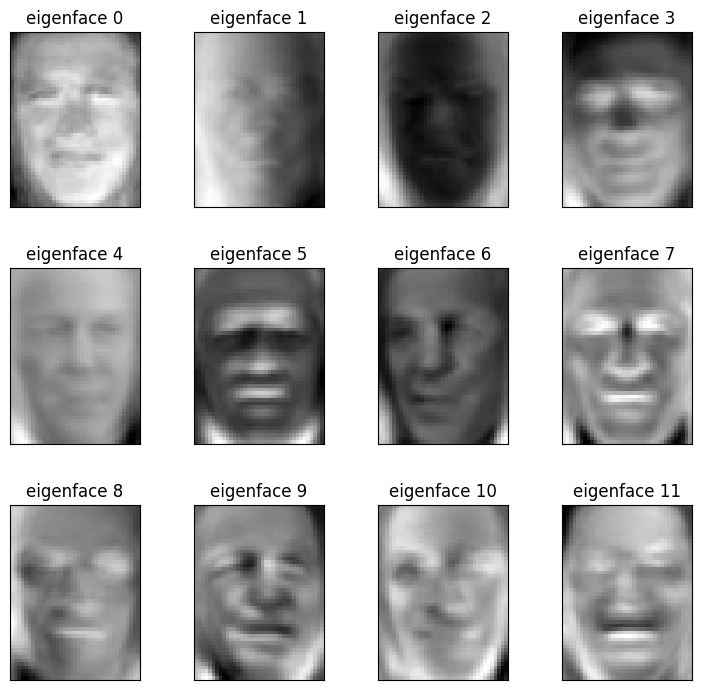

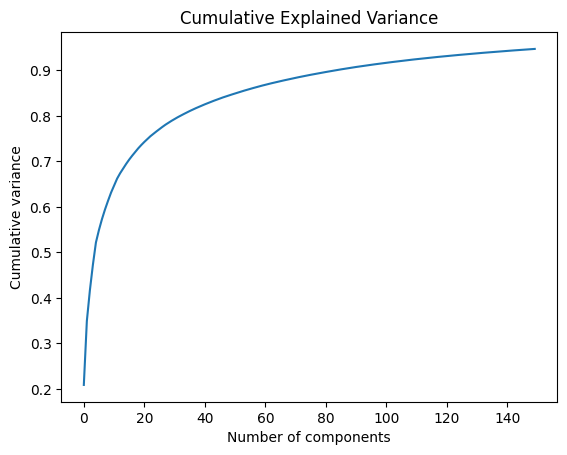

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Visualizing the eigenfaces
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# Reshape the top eigenfaces for visualization
eigenfaces = components_torch.T.reshape((n_components, h, w)).detach().numpy()

# Create titles for the eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]

# Plot the eigenfaces
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

# Plot the cumulative explained variance
explained_variance = (s ** 2) / (n_samples - 1)
total_var = explained_variance.sum().detach().numpy()
explained_variance_ratio = (explained_variance / total_var).detach().numpy()
ratio_cumsum = np.cumsum(explained_variance_ratio)

# Plot the compactness graph
plt.plot(np.arange(n_components), ratio_cumsum[:n_components])
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance')
plt.show()


--------------------PART 2.1---------------------

In [28]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.images  # Shape: (n_samples, h, w)
y = lfw_people.target

In [27]:
print(f"X_min: {X.min()}, X_max: {X.max()}")

X_min: 0.0, X_max: 0.003921568859368563


In [29]:
X = X[:, np.newaxis, :, :]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

In [31]:
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

In [32]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes, h, w):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # First Conv Layer
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)  # Second Conv Layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 kernel
        self.relu = nn.ReLU()

        # Fully connected layers (dense layers)
        self.fc1 = nn.Linear(32 * (h // 4) * (w // 4), 128)  # Adjust size after pooling
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)  # (N, 32, H/2, W/2)
        x = self.relu(self.conv2(x))
        x = self.pool(x)  # (N, 32, H/4, W/4)

        # Flatten the feature maps
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [34]:
# Get number of classes and image size from dataset
num_classes = len(lfw_people.target_names)
h, w = X.shape[2], X.shape[3]

# Initialize model, loss function, and optimizer
model = CNNClassifier(num_classes=num_classes, h=h, w=w)
criterion = nn.CrossEntropyLoss()  # Categorical Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam Optimizer

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNNClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=3456, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)

In [36]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%')


Epoch [1/10], Loss: 0.5443, Accuracy: 81.99%
Epoch [2/10], Loss: 0.4447, Accuracy: 85.20%
Epoch [3/10], Loss: 0.4058, Accuracy: 87.89%
Epoch [4/10], Loss: 0.3713, Accuracy: 87.99%
Epoch [5/10], Loss: 0.3568, Accuracy: 87.89%
Epoch [6/10], Loss: 0.2760, Accuracy: 91.30%
Epoch [7/10], Loss: 0.2548, Accuracy: 92.24%
Epoch [8/10], Loss: 0.2128, Accuracy: 93.27%
Epoch [9/10], Loss: 0.1772, Accuracy: 94.93%
Epoch [10/10], Loss: 0.1372, Accuracy: 96.38%


In [37]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f'Test Accuracy: {100 * correct/total:.2f}%')

Test Accuracy: 86.02%


PART 2.3

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Preprocessing (Normalization + Augmentation)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

# CNN Model
class FastCIFAR10CNN(nn.Module):
    def __init__(self):
        super(FastCIFAR10CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Instantiate model
model = FastCIFAR10CNN().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30  # Adjust to find the best speed/accuracy tradeoff

def train_model():
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%')

def test_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

# Training
train_model()
# Testing
test_model()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30], Loss: 2.0474, Accuracy: 36.88%
Epoch [2/30], Loss: 1.2113, Accuracy: 56.22%
Epoch [3/30], Loss: 0.9970, Accuracy: 64.56%
Epoch [4/30], Loss: 0.8814, Accuracy: 68.95%


PART 3.3

Epoch 1, Generator Loss: 3.4841344356536865, Discriminator Loss: 0.14760100841522217
Epoch 2, Generator Loss: 2.0559751987457275, Discriminator Loss: 0.5727499127388
Epoch 3, Generator Loss: 1.1464290618896484, Discriminator Loss: 0.9842044115066528
Epoch 4, Generator Loss: 1.129758596420288, Discriminator Loss: 0.9727218151092529
Epoch 5, Generator Loss: 1.0281144380569458, Discriminator Loss: 1.0789082050323486
Epoch 6, Generator Loss: 0.9255789518356323, Discriminator Loss: 1.1816117763519287
Epoch 7, Generator Loss: 0.8731639981269836, Discriminator Loss: 1.2540241479873657
Epoch 8, Generator Loss: 0.8579995036125183, Discriminator Loss: 1.2862443923950195
Epoch 9, Generator Loss: 0.8121994137763977, Discriminator Loss: 1.3555123805999756
Epoch 10, Generator Loss: 0.7779373526573181, Discriminator Loss: 1.4255461692810059


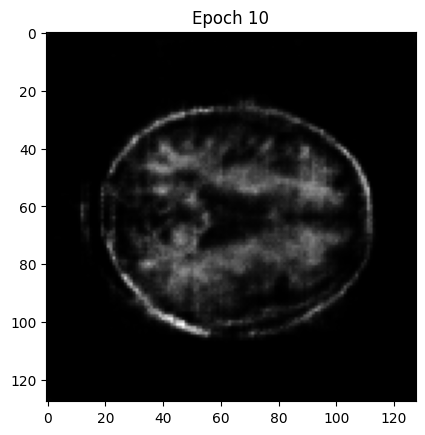

Epoch 11, Generator Loss: 0.7408355474472046, Discriminator Loss: 1.439870834350586
Epoch 12, Generator Loss: 0.7459911108016968, Discriminator Loss: 1.4255610704421997
Epoch 13, Generator Loss: 0.7359375953674316, Discriminator Loss: 1.4199527502059937
Epoch 14, Generator Loss: 0.7377380728721619, Discriminator Loss: 1.421897053718567
Epoch 15, Generator Loss: 0.7596336603164673, Discriminator Loss: 1.387494683265686
Epoch 16, Generator Loss: 0.7594881057739258, Discriminator Loss: 1.380998969078064
Epoch 17, Generator Loss: 0.7643036246299744, Discriminator Loss: 1.3865058422088623
Epoch 18, Generator Loss: 0.7840760350227356, Discriminator Loss: 1.334974765777588
Epoch 19, Generator Loss: 0.7564991116523743, Discriminator Loss: 1.3774842023849487
Epoch 20, Generator Loss: 0.7690219283103943, Discriminator Loss: 1.3522001504898071


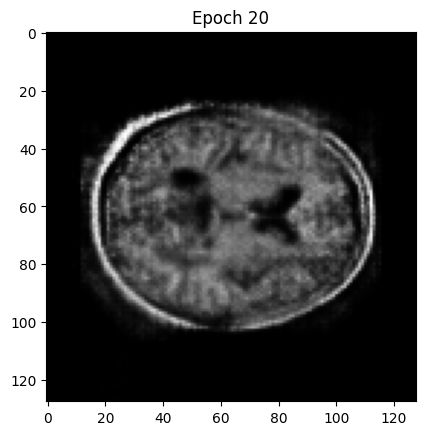

Epoch 21, Generator Loss: 0.7666757106781006, Discriminator Loss: 1.3561687469482422
Epoch 22, Generator Loss: 0.7760149836540222, Discriminator Loss: 1.328598141670227
Epoch 23, Generator Loss: 0.8091381788253784, Discriminator Loss: 1.2935950756072998
Epoch 24, Generator Loss: 0.7720838189125061, Discriminator Loss: 1.3524324893951416
Epoch 25, Generator Loss: 0.7855023145675659, Discriminator Loss: 1.3275572061538696
Epoch 26, Generator Loss: 0.8562206625938416, Discriminator Loss: 1.2697296142578125
Epoch 27, Generator Loss: 0.7885133624076843, Discriminator Loss: 1.329928994178772
Epoch 28, Generator Loss: 0.7941146492958069, Discriminator Loss: 1.3202708959579468
Epoch 29, Generator Loss: 0.8125147819519043, Discriminator Loss: 1.3130747079849243
Epoch 30, Generator Loss: 0.7813848257064819, Discriminator Loss: 1.3337013721466064


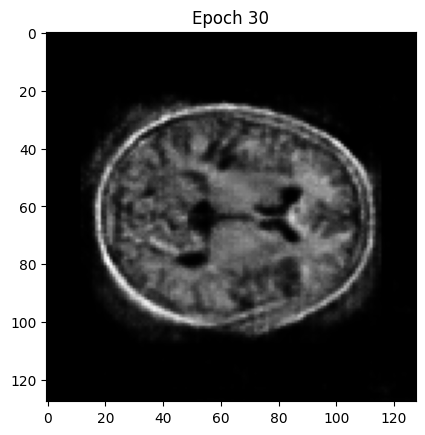

Epoch 31, Generator Loss: 0.8259611129760742, Discriminator Loss: 1.2835885286331177
Epoch 32, Generator Loss: 0.8119687438011169, Discriminator Loss: 1.2970802783966064
Epoch 33, Generator Loss: 0.8359350562095642, Discriminator Loss: 1.2800946235656738
Epoch 34, Generator Loss: 0.8124748468399048, Discriminator Loss: 1.3035998344421387
Epoch 35, Generator Loss: 0.8295741677284241, Discriminator Loss: 1.2849899530410767
Epoch 36, Generator Loss: 0.8182451128959656, Discriminator Loss: 1.2976431846618652
Epoch 37, Generator Loss: 0.8397029638290405, Discriminator Loss: 1.2872283458709717
Epoch 38, Generator Loss: 0.849515974521637, Discriminator Loss: 1.2839491367340088
Epoch 39, Generator Loss: 0.8413441181182861, Discriminator Loss: 1.2812165021896362
Epoch 40, Generator Loss: 0.8338021039962769, Discriminator Loss: 1.2869267463684082


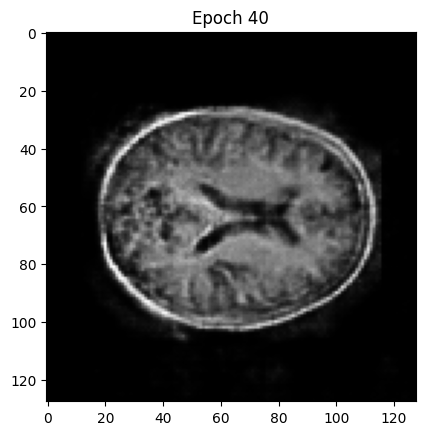

Epoch 41, Generator Loss: 0.8266251683235168, Discriminator Loss: 1.2913161516189575
Epoch 42, Generator Loss: 0.8289152979850769, Discriminator Loss: 1.2951723337173462
Epoch 43, Generator Loss: 0.8416537046432495, Discriminator Loss: 1.2826815843582153
Epoch 44, Generator Loss: 0.8360288739204407, Discriminator Loss: 1.2769861221313477
Epoch 45, Generator Loss: 0.8413974642753601, Discriminator Loss: 1.2847245931625366
Epoch 46, Generator Loss: 0.8691651821136475, Discriminator Loss: 1.2666748762130737
Epoch 47, Generator Loss: 0.8984267711639404, Discriminator Loss: 1.260860562324524
Epoch 48, Generator Loss: 0.8730677962303162, Discriminator Loss: 1.262612223625183
Epoch 49, Generator Loss: 0.8771997690200806, Discriminator Loss: 1.2666780948638916
Epoch 50, Generator Loss: 0.85950767993927, Discriminator Loss: 1.2716063261032104


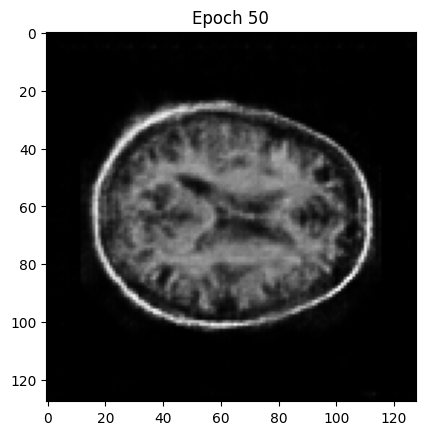

In [30]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

# Generator model
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        # Final layer should output 128x128x1 images
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Loss function for GAN
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers for both generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define GAN training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

# Training function
def train(dataset, epochs):
    for epoch in range(epochs):
        gen_loss_avg = 0
        disc_loss_avg = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_avg += gen_loss
            disc_loss_avg += disc_loss

        print(f'Epoch {epoch+1}, Generator Loss: {gen_loss_avg / len(dataset)}, Discriminator Loss: {disc_loss_avg / len(dataset)}')

        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch+1)

# Function to generate and save images
def generate_and_save_images(model, epoch):
    noise = tf.random.normal([1, 100])
    generated_image = model(noise, training=False)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.title(f'Epoch {epoch}')
    plt.show()


# Load preprocessed MRI dataset
def load_mri_data(data_dir):
    image_list = []
    for filename in os.listdir(data_dir):
        img = tf.io.read_file(os.path.join(data_dir, filename))
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, (128, 128))  # Resize to 128x128
        img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
        image_list.append(img)
    return np.array(image_list)

# Set parameters and load data
BUFFER_SIZE = 60000
BATCH_SIZE = 32
EPOCHS = 50
train_images = load_mri_data('C:/Hemil/UQ/Notes/sem2 2024/Pattern Recognition & Analysis/practicals/practical 2/keras_png_slices_data/keras_png_slices_data/keras_png_slices_train')

# Create dataset object
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Build the GAN
generator = build_generator()
discriminator = build_discriminator()

# Train the GAN
train(train_dataset, EPOCHS)
